In [1]:
from torch.utils.data import Dataset, Subset, DataLoader
import os
import torch
import pandas as pd
from PIL import Image
import numpy as np
import torchvision.transforms as transforms
from sklearn.metrics import confusion_matrix, roc_auc_score, balanced_accuracy_score, accuracy_score, recall_score, precision_score

import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import argparse
import wandb
import copy 


In [4]:
train_csv = pd.read_csv("/storage/research/med_mlm/data/isic2024/train-metadata.csv")


/scratch/local/15630824/ipykernel_422330/3754186584.py:1: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  train_csv = pd.read_csv("/storage/research/med_mlm/data/isic2024/train-metadata.csv")


In [5]:
train_csv["target"].value_counts()

target
0    400666
1       393
Name: count, dtype: int64

In [6]:
train_csv.head()

,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.517282
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,...,IL_6727506,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455
2,ISIC_0015864,0,IP_6724798,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.804040
3,ISIC_0015902,0,IP_4111386,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.989998
4,ISIC_0024200,0,IP_8313778,55.0,male,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,70.442510


In [7]:
# check if output files exist, if it does not, create it
if not os.path.exists("/storage/research/med_mlm/data/isic2024/train-split1.csv"):
    # set random seed
    np.random.seed(100) #split0: 42, split1: 100
    # divide train into train validation test using patient_id
    train_patients = train_csv['patient_id'].unique()
    np.random.shuffle(train_patients)
    train_patients = train_patients[:int(0.6*len(train_patients))]
    val_patients = train_patients[int(0.6*len(train_patients)):int(0.8*len(train_patients))]
    test_patients = train_patients[int(0.8*len(train_patients)):]

    # Convert patients to isic_id
    train_isic_ids = train_csv[train_csv['patient_id'].isin(train_patients)]['isic_id']
    val_isic_ids = train_csv[train_csv['patient_id'].isin(val_patients)]['isic_id']
    test_isic_ids = train_csv[train_csv['patient_id'].isin(test_patients)]['isic_id']

    # lets save different files for each split
    train_csv[train_csv['isic_id'].isin(train_isic_ids)].to_csv("/storage/research/med_mlm/data/isic2024/train-split1.csv", index=False)
    train_csv[train_csv['isic_id'].isin(val_isic_ids)].to_csv("/storage/research/med_mlm/data/isic2024/val-split1.csv", index=False)
    train_csv[train_csv['isic_id'].isin(test_isic_ids)].to_csv("/storage/research/med_mlm/data/isic2024/test-split1.csv", index=False)


In [ ]:
a

: 

In [8]:
# add current directory to path
import sys
sys.path.append("/storage/homefs/ab24c492/subgroups")
from data_loader import CSVDataset, CSVDatasetWithName


In [10]:

root = "/storage/research/med_mlm/data/isic2024/train-image/image/"
csv_file = "/storage/research/med_mlm/data/isic2024/{}-split0.csv"
image_field = "isic_id"
target_field = "target"
bias_field = None

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

train_set = CSVDatasetWithName(root, csv_file.format("train"), image_field, target_field, transform=transform, add_extension=".jpg")
val_set = CSVDatasetWithName(root, csv_file.format("val"), image_field, target_field, transform=transform, add_extension=".jpg")
test_set = CSVDatasetWithName(root, csv_file.format("test"), image_field, target_field, transform=transform, add_extension=".jpg")


dl_tr = DataLoader(train_set, batch_size=32, shuffle=True, sampler=None, num_workers=8)
dl_val = DataLoader(val_set, batch_size=32, shuffle=True, sampler=None, num_workers=8)
#dl_test_same = DataLoader(test_set_same, batch_size=args.bs, shuffle=True, sampler=None, num_workers=8)
dl_test = DataLoader(test_set, batch_size=32, shuffle=True, sampler=None, num_workers=8)


../../data_loader.py:27: DtypeWarning: Columns (52) have mixed types. Specify dtype option on import or set low_memory=False.
  self.data = pd.read_csv(csv_file)


Found 253136 images from 2 classes.
    Class '0' (0): 252910 images.
    Class '1' (1): 226 images.
Samples per subgroup (class and bias):
    Class '0' (0), Bias '0' (0): 252910 samples
    Class '0' (0), Bias '1' (1): 0 samples
    Class '1' (1), Bias '0' (0): 0 samples
    Class '1' (1), Bias '1' (1): 226 samples


../../data_loader.py:27: DtypeWarning: Columns (52) have mixed types. Specify dtype option on import or set low_memory=False.
  self.data = pd.read_csv(csv_file)
../../data_loader.py:27: DtypeWarning: Columns (52) have mixed types. Specify dtype option on import or set low_memory=False.
  self.data = pd.read_csv(csv_file)


Found 53826 images from 2 classes.
    Class '0' (0): 53775 images.
    Class '1' (1): 51 images.
Samples per subgroup (class and bias):
    Class '0' (0), Bias '0' (0): 53775 samples
    Class '0' (0), Bias '1' (1): 0 samples
    Class '1' (1), Bias '0' (0): 0 samples
    Class '1' (1), Bias '1' (1): 51 samples
Found 46916 images from 2 classes.
    Class '0' (0): 46866 images.
    Class '1' (1): 50 images.
Samples per subgroup (class and bias):
    Class '0' (0), Bias '0' (0): 46866 samples
    Class '0' (0), Bias '1' (1): 0 samples
    Class '1' (1), Bias '0' (0): 0 samples
    Class '1' (1), Bias '1' (1): 50 samples


/storage/homefs/ab24c492/.conda/envs/glucobench/lib/python3.10/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/storage/homefs/ab24c492/.conda/envs/glucobench/lib/python3.10/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


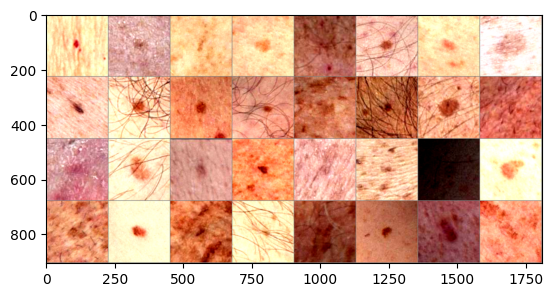

0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
('ISIC_2395048', 'ISIC_4156845', 'ISIC_7978164', 'ISIC_5877718', 'ISIC_4332571', 'ISIC_0083716', 'ISIC_9997474', 'ISIC_9834500', 'ISIC_7715647', 'ISIC_1149111', 'ISIC_9208268', 'ISIC_3441116', 'ISIC_9413576', 'ISIC_6099042', 'ISIC_9301281', 'ISIC_1831618', 'ISIC_8210356', 'ISIC_7480046', 'ISIC_4798385', 'ISIC_3075359', 'ISIC_7037072', 'ISIC_4209521', 'ISIC_0093547', 'ISIC_2563177', 'ISIC_1458256', 'ISIC_8631372', 'ISIC_2933795', 'ISIC_0768621', 'ISIC_2449517', 'ISIC_1679957', 'ISIC_7033084', 'ISIC_3093514')


In [16]:
# lets show some of the loaded images
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

for (images, labels, _), names in dl_tr:
    # show images
    imshow(torchvision.utils.make_grid(images))
    # print labels
    print(' '.join(f'{labels[j]}' for j in range(32)))
    print(names[:32])
    break



In [25]:
def partial_auc(gts, preds, min_tpr=0.8):
    from sklearn.metrics import roc_curve, auc, roc_auc_score

    # rescale the target. set 0s to 1s and 1s to 0s (since sklearn only has max_fpr)
    v_gt = abs(np.asarray(gts)-1)
    
    # flip the submissions to their compliments
    v_pred = -1.0*np.asarray(preds)

    max_fpr = abs(1-min_tpr)

    # using sklearn.metric functions: (1) roc_curve and (2) auc
    fpr, tpr, _ = roc_curve(v_gt, v_pred, sample_weight=None)
    if max_fpr is None or max_fpr == 1:
        return auc(fpr, tpr)
    if max_fpr <= 0 or max_fpr > 1:
        raise ValueError("Expected min_tpr in range [0, 1), got: %r" % min_tpr)
        
    # Add a single point at max_fpr by linear interpolation
    stop = np.searchsorted(fpr, max_fpr, "right")
    x_interp = [fpr[stop - 1], fpr[stop]]
    y_interp = [tpr[stop - 1], tpr[stop]]
    tpr = np.append(tpr[:stop], np.interp(max_fpr, x_interp, y_interp))
    fpr = np.append(fpr[:stop], max_fpr)
    partial_auc = auc(fpr, tpr)
    return partial_auc


# Test the partial_auc function
solution = np.random.randint(0, 2, 100)
submission = np.random.rand(100)
partial_auc(solution, submission, min_tpr=0.8)

0.022383252818035416